# Digits recognition with clustering

`sklearn` has some built-in datasets. One of them is composed of small images of digits and the corresponding digit it represents (the label).

## Loading and visualizing the dataset

In [1]:
# Look at the documentation of the function load_digits.
# Use it to get the data (both X and y).
from sklearn.datasets import load_digits

# -- Answer --
#?load_digits
# By looking at the documentation, one can see that the
# function `load_digits()̣` returns a dictionary containing
# different data in each of its attributes. The interesting
# ones are named `data` (our X) and `target` (our y).
# I could write:
# X, y = load_digits(return_X_y=True)
# which only returns the interesting fields but since I will
# need the images for the next question, I load it entirely.
data = load_digits()
X = data["data"]
y = data["target"]

In [2]:
# How many samples does this dataset contain?

# -- Answer --
print("There are {} samples in the digits dataset.".
    format(len(X)))

There are 1797 samples in the digits dataset.


In [3]:
# How many samples of class '7' are there in the dataset?

# -- Answer --
# The condition `y == 7` returns a numpy array of booleans
# where values are True each time the label is 7. Then
# np.sum() gives the number of occurrences of `True` in the 
# array, since True is evaluated as 1 and False as 0. The
# number of occurrences of True is the number of labels
# equal to 7.
print("There are {} samples of the class 7 in the dataset.".
    format((y == 7).sum()))

There are 179 samples of the class 7 in the dataset.


There are 64 features in each input vector.


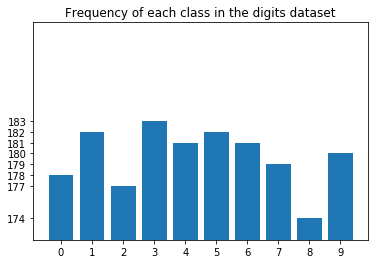

In [4]:
# How many features are there in each input vector?
# Print the frequency of each class as an histogram.

# -- Answer --
print("There are {} features in each input vector.".
    format(X.shape[1]))

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# np.histogram() counts the number of values in each bucket,
# where the buckets are spread along [0-9] (the possible
# clasess). We indicate that we want the same number of
# buckets as the number of labels.
occurrences = np.histogram(
                y, bins=len(data["target_names"]))[0]
plt.bar(data["target_names"], occurrences)

# Visualization is better if mininal value on y-axis is not 0.
plt.ylim(min(occurrences) - 2)

# Modify the names on x-axis and y-axis (better readability)
plt.xticks(data["target_names"])
plt.yticks(sorted(list(set(occurrences))))
plt.title("Frequency of each class in the digits dataset")
plt.show()


In [5]:
# Use the fonction imshow() of the plt library to represent
# as an image:
#   - 3 different samples of the class "9"
#   - 3 different samples of the class "6"
#   - 3 different samples of the class "5"

# -- Answer --
# First, we need to get the images of the "9", the "6" and
# the "5". The images are in the `images` field of the
# `data` variable, but it contains all types of classes. We
# use boolean arrays to only select the images of a certain
# class.
all_9 = data["images"][y == 9]
all_6 = data["images"][y == 6]
all_5 = data["images"][y == 5]

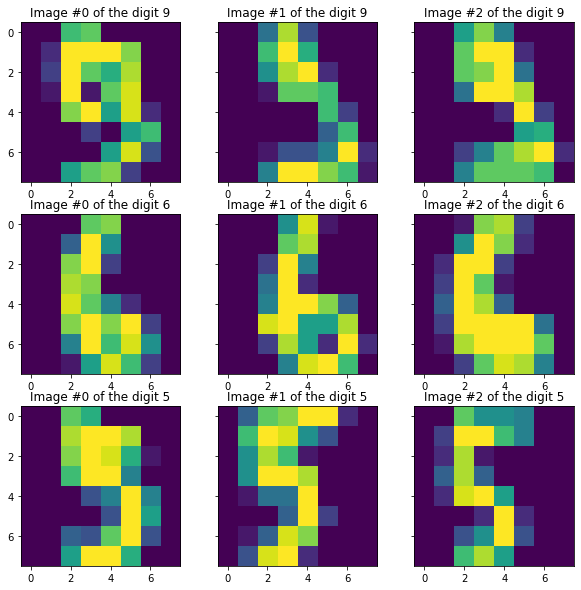

In [6]:
# Print all the images into the same plot (use subplots()
# with a size of 3x3 so that the first row contains "9", the
# second row contains "6" and the third row contains "5")

# -- Answer --
fig, ax = plt.subplots(3,3, figsize=(10, 10),
                       sharex=False, sharey=True)

# First row contains "9"
for i in range(3):
    ax[0][i].imshow(all_9[i])
    ax[0][i].set_title("Image #{} of the digit 9".format(i))

# Second row contains "6"
for i in range(3):
    ax[1][i].imshow(all_6[i])
    ax[1][i].set_title("Image #{} of the digit 6".format(i))

# Third row contains "5"
for i in range(3):
    ax[2][i].imshow(all_5[i])
    ax[2][i].set_title("Image #{} of the digit 5".format(i))
    
plt.show()

## Predicting digits with K-means

In [7]:
# Separate the dataset into a train and test size with
# random_state = 0.

# -- Answer --
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                   random_state=0)

In [8]:
# With the class KMeans, create a model that clusterize the 
# training data. Use the right number of clusters.

# -- Answer --
from sklearn.cluster import KMeans

# We indicate that we want the same number of clusters as
# the number of classes.
model = KMeans(n_clusters=len(data["target_names"]),
               random_state=0)
model.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [9]:
# The model learns 2 things:
#   - the position of each centroid (model.cluster_centers_)
#   - the id of the cluster to which each point belongs (model.labels_)
#
# Use the above information to build, for each centroid,
# the list of points and their label belonging to that 
# centroid.

# -- Answer --
# We associate each centroid with a list of tuples. Each
# tuple is composed of (point_id, label_of_point_id). Each
# centroid only has in its list the points that have been
# associated to it by the kmeans model.
from collections import defaultdict

points_near_centroid = defaultdict(list)
for point_id in range(len(X_train)):
    centroid_assigned = model.labels_[point_id]
    points_near_centroid[centroid_assigned].append(
        (point_id, y_train[point_id]))

In [10]:
# Then build a mapping between a cluster id and the class it
# represents (use a dictionary for this).

# -- Answer --
# We use what we have built at the previous question. For
# each centroid, we iterate over its tuple list and find
# what is the most frequent label among the tuples. We can
# assume that the most frequent label is the digit class
# this centroid represents.
from collections import Counter

"""Return the most frequent label in the tuple list. Each
tuple is composed of (point_id, label_of_point_id)."""
def most_frequent_label(tuple_list):
    all_labels = [t[1] for t in tuple_list]
    c = Counter(all_labels)
    # most_common() return a list of tuple (elem, occurrence)
    # Take the most common element, then the first value of
    # tuple which is the element itself (not its occurrence).
    return c.most_common(1)[0][0]

# Go over each centroid and find its most common label.
label_of_centroid = {}
for centroid, tuple_list in points_near_centroid.items():
    label_of_centroid[centroid] = most_frequent_label(tuple_list)

# We can look at the mapping between a centroid id and the
# digit it represents. We can see that it is not perfect
# because there is no centroid representing the digit "9"
# while two centroids represent the digit "1".
for k, v in label_of_centroid.items():
    print("Centroid #{} => Digit #{}".format(k, v))

Centroid #3 => Digit #2
Centroid #2 => Digit #8
Centroid #4 => Digit #3
Centroid #9 => Digit #7
Centroid #0 => Digit #1
Centroid #7 => Digit #4
Centroid #5 => Digit #6
Centroid #6 => Digit #5
Centroid #1 => Digit #0
Centroid #8 => Digit #1


In [11]:
# Look at the documentation of the .predict() method of your
# model. Use it to find the class predicted by your model
# for each point of your test set.

# -- Answer --
centroid_predicted = model.predict(X_test)
label_predicted = [label_of_centroid[c]
                   for c in centroid_predicted]

In [12]:
# What is the accuracy of your KMeans model on the test set?

# -- Answer --
# We need to compare the values of the arrays:
#   - label_predicted
#   - y_test
# Each time the values match, the prediction is correct. The
# accuracy is the ratio between the number correct
# predictions and the number of samples in the test set.
correct  = np.sum(np.array(label_predicted) == y_test)
accuracy = correct / len(y_test)
print("Accuracy of the model: {:.2f}.".format(accuracy))

Accuracy of the model: 0.78.


## Combining PCA and Kmeans for prediction

In [13]:
# Use the PCA algorithm to transform the digits data
# (all of them i.e. both train and test) into a
# 3-dimensional dataset.

# -- Answer --
# First we create a PCA model and feed it with all the X data.
from sklearn.decomposition import PCA
pca = PCA(n_components=3, random_state=0)
pca.fit(X)

# Then we use it to transform X_train and X_test. y_train
# and y_test do not have to be transformed because they are
# 1D arrays (only composed of labels).
X_train_3d = pca.transform(X_train)
X_test_3d  = pca.transform(X_test)

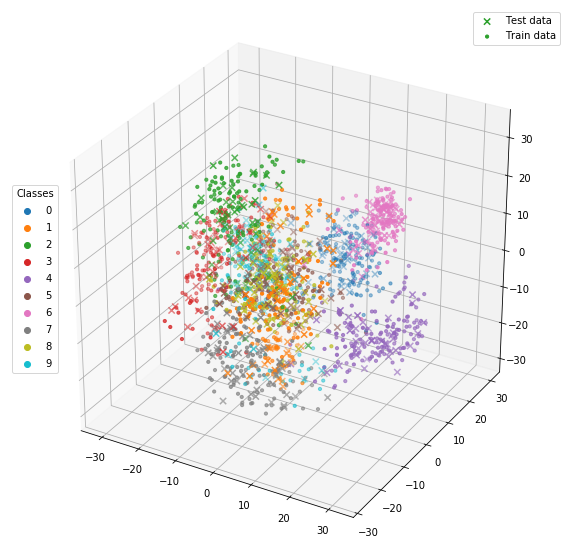

In [14]:
# Print the reduced dataset on a 3D figure.

# -- Answer --
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

# To have the figure inside an external window.
#%matplotlib notebook

# To have the figure inside the notebook.
%matplotlib inline

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

# I want each class to be printed with a different color.
# By default, Matplotlib uses gradient colors which means
# that two consecutive classes (like 2 and 3) will have
# similar colors and will be difficult to differenciate.
# I choose a colorscheme where consecutive colors are
# strongly different.
theme = cm.tab10

_ = ax.scatter(X_test_3d[:,0], X_test_3d[:,1], X_test_3d[:,2],
        c=y_test, s=40, marker="x", label="Test data",
        cmap=theme)
_ = ax.scatter(X_train_3d[:,0], X_train_3d[:,1], X_train_3d[:,2],
        c=y_train, s=10, label="Train data", cmap=theme)

legend_classes = ax.legend(*_.legend_elements(),
    loc="center left", title="Classes")
ax.add_artist(legend_classes) # add the legend for classes color
plt.legend() # add the legend for type of point (train/test)
plt.show()

In [15]:
# Train another KMeans on the 3D dataset.

# -- Answer --
# Train a kmeans model on the 3d reduced dataset
model_3d = KMeans(n_clusters=len(data["target_names"]),
                  random_state=0)
model_3d.fit(X_train_3d)

# Build the mapping centroid_id <-> digit it represents
labels_near_centroid_3d = defaultdict(list)
for point_id in range(len(X_train_3d)):
    c = model_3d.labels_[point_id]
    labels_near_centroid_3d[c].append(y_train[point_id])
    
label_of_centroid_3d = {}
for centroid, labels in labels_near_centroid_3d.items():
    most_freq_label = Counter(labels).most_common(1)[0][0]
    label_of_centroid_3d[centroid] = most_freq_label

# We can look at the mapping between a centroid id and the 
# digit it represents. This time, the class "9" has a
# mapping but the class "5" does not. This time, the digit
# "7" has two different centroid representing it.
for k, v in label_of_centroid_3d.items():
    print("Centroid #{} => Digit #{}".format(k, v))

Centroid #9 => Digit #2
Centroid #2 => Digit #8
Centroid #4 => Digit #9
Centroid #3 => Digit #7
Centroid #6 => Digit #1
Centroid #0 => Digit #4
Centroid #1 => Digit #3
Centroid #7 => Digit #6
Centroid #8 => Digit #0
Centroid #5 => Digit #7


In [16]:
# Compare its accuracy against the previous KMeans model.
# Do you get better results?

# -- Answer --
label_predicted_3d = np.array([label_of_centroid_3d[c]
                     for c in model_3d.predict(X_test_3d)])
correct = label_predicted_3d == y_test
accuracy_3d = np.sum(correct) / len(y_test)
print("Accuracy of the model on 3d data: {:.2f}".format(
    accuracy_3d))

Accuracy of the model on 3d data: 0.67


We can see that the accuracy with the 3d dataset is worse than with the non reduced dataset: 0.67 vs. 0.78. Several possible explanations:
* the dataset is hard to classify: we printed the images of some 9, 6, 5 and some are hard to differenciate if we don't have the corresponding labels (some "5" can be seen as a "9"). The model therefore needs as much as possible information to perform well, and cannot achieve a good classification accuracy with only 3 dimensions per input vector.
* the dataset already has a small number of features: the images only have 64 pixels. PCA is usually used when the number of features is larger than 100. Reducing it to only 3 dimensions induce a large loss of information.
* the number of clusters is not correct: we set the number of cluster to match the number of classes (10). But some samples with different digits are close to each other (like the "5" and the "9") and then belong to the same cluster, even if they do not have the same class. With a greater number of centroids, the size of each cluster is reduced and the probability of two different digits belonging to the same cluster is reduced, thus the accuracy should increase.